### #2

Kaggle competition: [\[link\]](https://www.kaggle.com/competitions/titanic/)

Entry by Robin P.M. Kras

### ⭐ 1. Introduction & Overview


The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).[Problem description]

### 🔹 2. Import Libraries & Set Up


In [263]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

# Feature Importance & Explainability
import shap

# Settings
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

print("Libraries loaded. Ready to go!")

Libraries loaded. Ready to go!


### 🔹 3. Load & Explore Data


In [264]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [265]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [266]:
train.shape

(891, 12)

In [267]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [268]:
# Quick summary of dataset
train.describe()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 🔹 4. Data Visualization & EDA



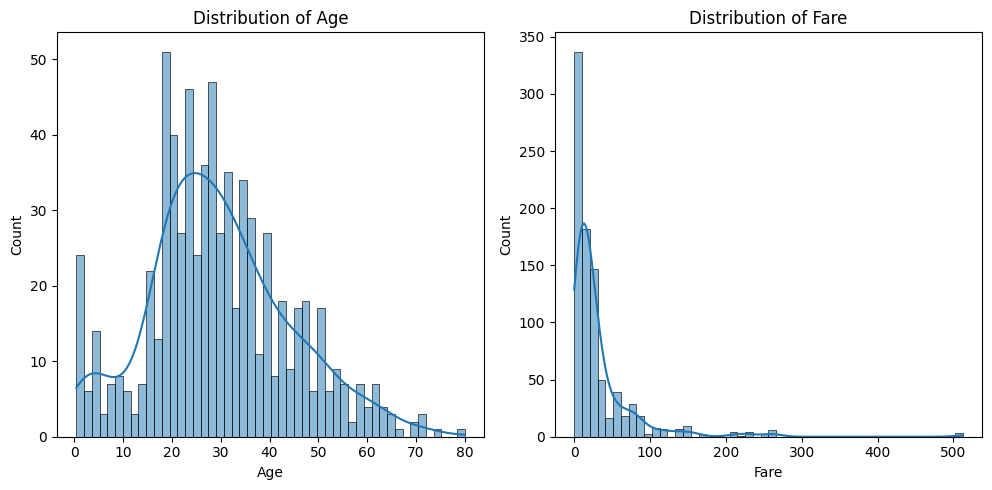

In [269]:
float_cols = [col for col in train.columns if train[col].dtype == "float64"]

cols_per_row = 3
num_plots = len(float_cols)
rows = (num_plots // cols_per_row) + (num_plots % cols_per_row > 0) 

fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 5 * rows)) 
axes = axes.flatten()  

for idx, col in enumerate(float_cols):
    sns.histplot(train[col], bins=50, kde=True, ax=axes[idx])
    axes[idx].set_title(f"Distribution of {col}")

for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

From the data we can see that most passengers were aged between 18-40.

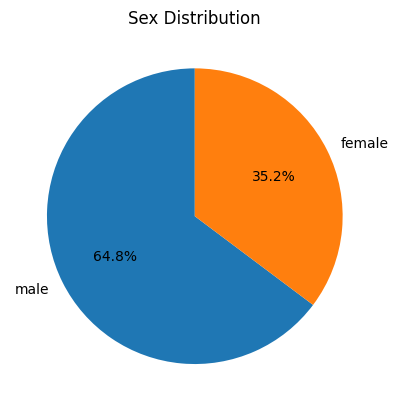

In [270]:
sex_counts = train["Sex"].value_counts()

plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Sex Distribution")
plt.show()

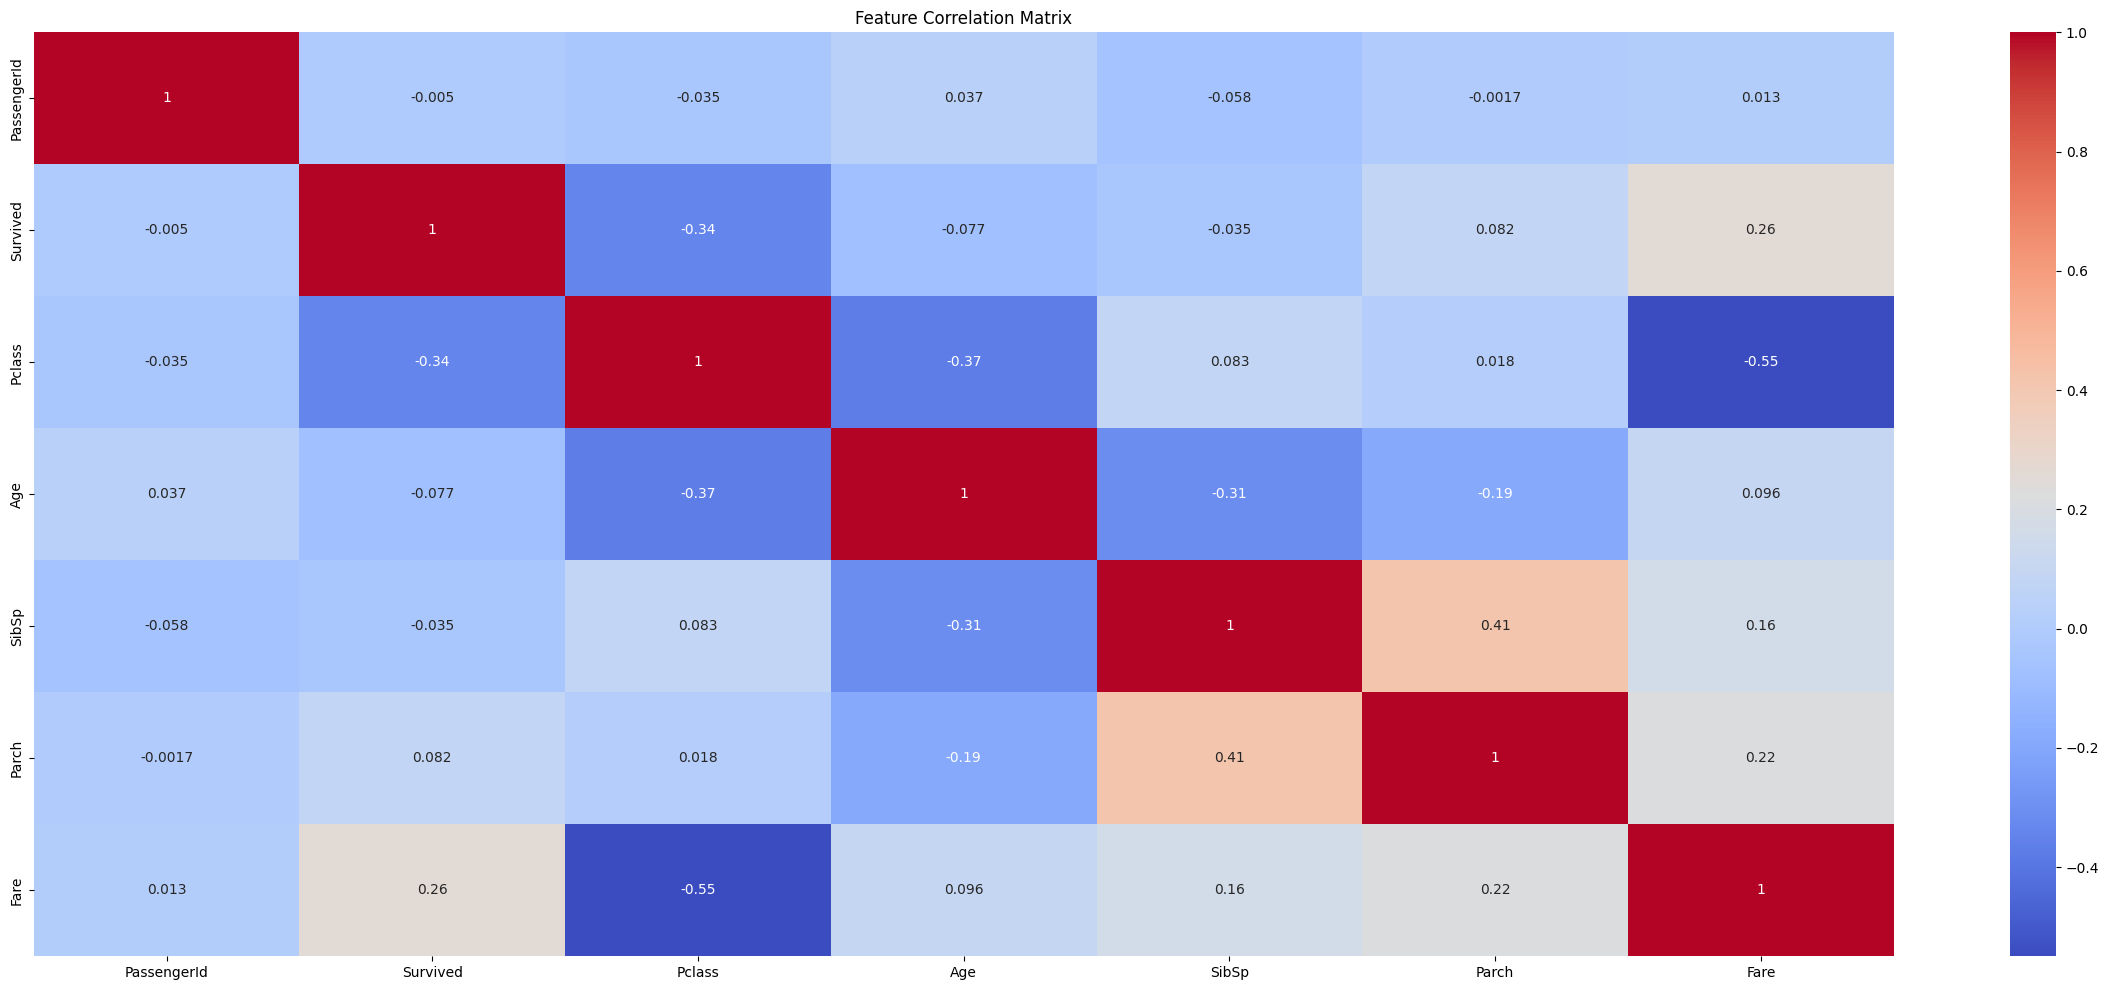

In [271]:
heatmap_train = pd.DataFrame()

for col in train.columns:
    if train[col].dtype == "float64" or train[col].dtype == "int64":
        heatmap_train[col] = train[col]

plt.figure(figsize=(30,12))
sns.heatmap(heatmap_train.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

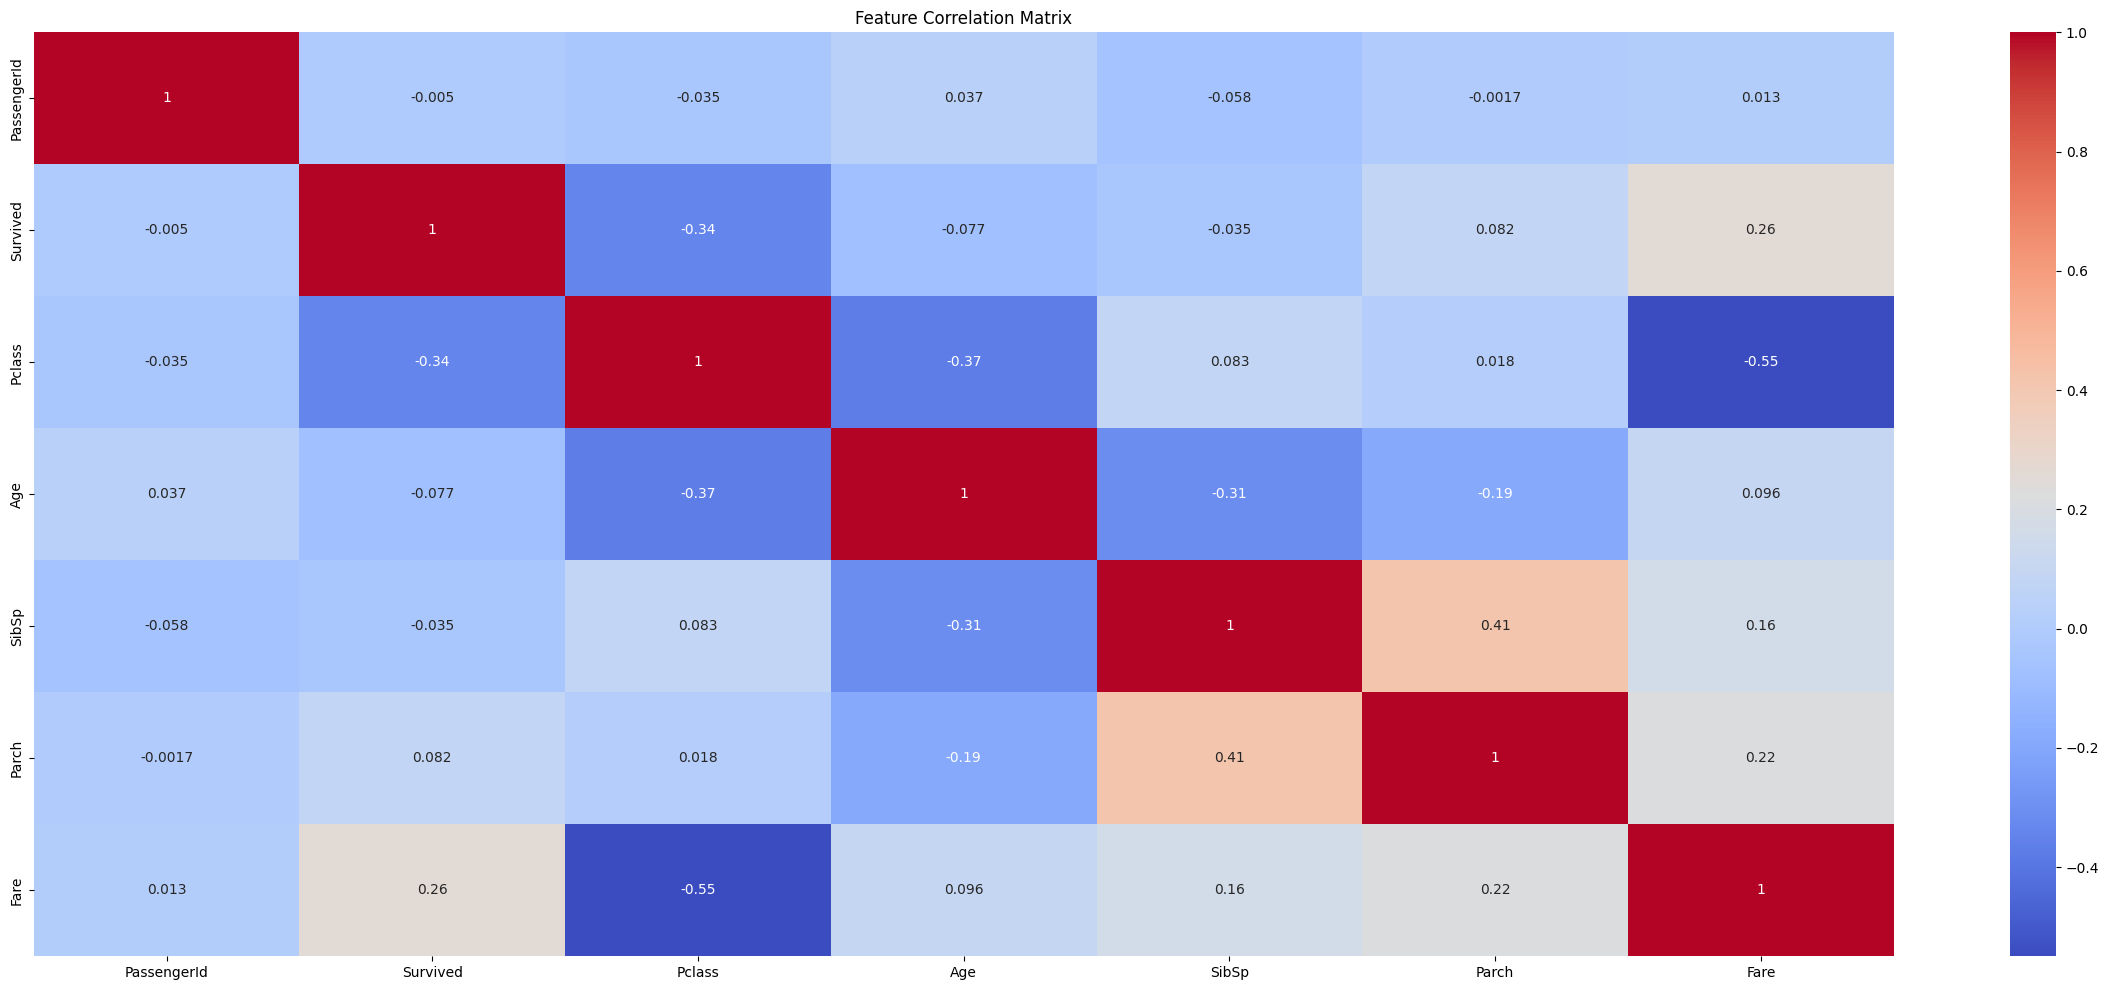

Highly correlated feature pairs (above threshold):
   Feature 1 Feature 2  Correlation
6   Survived    Pclass    -0.338481
10  Survived      Fare     0.257307
11    Pclass       Age    -0.369226
14    Pclass      Fare    -0.549500
15       Age     SibSp    -0.308247
18     SibSp     Parch     0.414838
20     Parch      Fare     0.216225


In [272]:
heatmap_train = train.select_dtypes(include=["float64", "int64"])

corr_matrix = heatmap_train.corr()

threshold = 0.2

high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)) 
    .stack()  
    .reset_index()
)

high_corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]
high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlation"].abs() > threshold]  

plt.figure(figsize=(30, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

print("Highly correlated feature pairs (above threshold):")
print(high_corr_pairs)

In [273]:
l1 = high_corr_pairs['Feature 1'].tolist()
l2 = high_corr_pairs['Feature 2'].tolist()
interesting_features = list(set(l1+l2))

interesting_features.remove('Survived')

print(interesting_features)

['Pclass', 'Parch', 'SibSp', 'Age', 'Fare']


### 🔹 5. Feature Engineering

In [274]:
print(f"Train set, null count: \n{train.isnull().sum()}")
print("\n")
print(f"Test set, null count: \n{test.isnull().sum()}")

Train set, null count: 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Test set, null count: 
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [275]:
train = train.drop(columns=["Name", "Cabin"])
test = test.drop(columns=["Name", "Cabin"])

In [276]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,female,35.0,1,0,113803,53.1000,S
4,5,0,3,male,35.0,0,0,373450,8.0500,S


In [277]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,male,34.5,0,0,330911,7.8292,Q
1,893,3,female,47.0,1,0,363272,7.0000,S
2,894,2,male,62.0,0,0,240276,9.6875,Q
3,895,3,male,27.0,0,0,315154,8.6625,S
4,896,3,female,22.0,1,1,3101298,12.2875,S


In [278]:
train['Ticket_type'] = train['Ticket'].apply(lambda x: x[0:3])
train['Ticket_type'] = train['Ticket_type'].astype('category')
train['Ticket_type'] = train['Ticket_type'].cat.codes

test['Ticket_type'] = test['Ticket'].apply(lambda x: x[0:3])
test['Ticket_type'] = test['Ticket_type'].astype('category')
test['Ticket_type'] = test['Ticket_type'].cat.codes

train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

In [279]:
train["Age"] = train["Age"].fillna(train["Age"].mean())

In [280]:
for col in train.columns:
    if train[col].dtype == "float64":
        train[col] = train[col].astype("int64")

In [281]:
train['Sex'] = train['Sex'].map({'male': 1, 'female': 0})
test['Sex'] = test['Sex'].map({'male': 1, 'female': 0})

In [282]:
data = [train, test]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'travelled_alone'] = 'No'
    dataset.loc[dataset['relatives'] == 0, 'travelled_alone'] = 'Yes'

In [283]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Ticket_type,relatives,travelled_alone
0,1,0,3,1,22,1,0,A/5 21171,7,S,124,1,No
1,2,1,1,0,38,1,0,PC 17599,71,C,137,1,No
2,3,1,3,0,26,0,0,STON/O2. 3101282,7,S,148,0,Yes
3,4,1,1,0,35,1,0,113803,53,S,3,1,No
4,5,0,3,1,35,0,0,373450,8,S,97,0,Yes


In [284]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Ticket_type,relatives,travelled_alone
0,892,3,1,34.5,0,0,330911,7.8292,Q,58,0,Yes
1,893,3,0,47.0,1,0,363272,7.0000,S,71,1,No
2,894,2,1,62.0,0,0,240276,9.6875,Q,32,0,Yes
3,895,3,1,27.0,0,0,315154,8.6625,S,55,0,Yes
4,896,3,0,22.0,1,1,3101298,12.2875,S,54,2,No


### 🔹 6. Model Selection: XGBoost

In [285]:
features = ["Pclass", "Sex", "SibSp", "Parch"]

X = pd.get_dummies(train[features])
X_test = pd.get_dummies(test[features])

y = train["Survived"]

model = xg.XGBClassifier(n_estimators=100, max_depth=3, random_state=SEED)
model.fit(X, y)

predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
